In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, MultiPolygon
from scipy.spatial import distance

import sys
sys.path.append('../class/')
from NSGA2 import NSGA2_XY

In [11]:
# 创建风场
from py_wake.examples.data.hornsrev1 import Hornsrev1Site
site = Hornsrev1Site()

# 创建风力机
from py_wake.wind_turbines import WindTurbine
from py_wake.wind_turbines.power_ct_functions import PowerCtTabular

u = np.array([0.0, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 9.5, 10.0, 10.5, 11.0, 11.5, 12.0, 12.5, 13.0, 13.5, 14.0, 14.5, 15.0, 15.5, 16.0, 16.5, 17.0, 17.5, 18.0, 18.5, 19.0, 19.5, 20.0, 20.5, 21.0, 21.5, 22.0, 22.5, 23.0, 23.5, 24.0, 24.5, 25.0, 25.01, 25.02, 50.0])
cp = np.array([0.0, 0.000000, 0.000000, 0.178085, 0.289075, 0.349022, 0.384728, 0.406059, 0.420228, 0.428823, 0.433873, 0.436223, 0.436845, 0.436575, 0.436511, 0.436561, 0.436517, 0.435903, 0.434673, 0.433230, 0.430466, 0.378869, 0.335199, 0.297991, 0.266092, 0.238588, 0.214748, 0.193981, 0.175808, 0.159835, 0.145741, 0.133256, 0.122157, 0.112257, 0.103399, 0.095449, 0.088294, 0.081836, 0.075993, 0.070692, 0.065875, 0.061484, 0.057476, 0.053809, 0.050447, 0.047358, 0.044518, 0.041900, 0.039483, 0.0, 0.0])
ct = np.array([0.0, 0.0, 0.0, 0.99, 0.99, 0.97373036, 0.92826162, 0.89210543, 0.86100905, 0.835423, 0.81237673, 0.79225789, 0.77584769, 0.7629228, 0.76156073, 0.76261984, 0.76169723, 0.75232027, 0.74026851, 0.72987175, 0.70701647, 0.54054532, 0.45509459, 0.39343381, 0.34250785, 0.30487242, 0.27164979, 0.24361964, 0.21973831, 0.19918151, 0.18131868, 0.16537679, 0.15103727, 0.13998636, 0.1289037, 0.11970413, 0.11087113, 0.10339901, 0.09617888, 0.09009926, 0.08395078, 0.0791188, 0.07448356, 0.07050731, 0.06684119, 0.06345518, 0.06032267, 0.05741999, 0.05472609, 0.0, 0.0])
power=0.5*1.225*(np.pi*63**2)*cp*u**3

wt = WindTurbine(name="NREL 5MW",
                 diameter=126.0,
                 hub_height=90.0,
                 powerCtFunction=PowerCtTabular(
                     ws=u,
                     ws_cutin=3,
                     ws_cutout=25,
                     power=power,
                     power_unit="W",
                     ct=ct))

# 创建模型
from py_wake import BastankhahGaussian
from py_wake.turbulence_models.stf import STF2017TurbulenceModel

wf_model = BastankhahGaussian(site, wt, turbulenceModel = STF2017TurbulenceModel())

# 创建边界
from py_wake.examples.data.hornsrev1 import wt_x, wt_y
point_index = [0, 7, 79, 72]
polygon = Polygon([
    [wt_x[i], wt_y[i]]
    for i in point_index
])
multi_polygon = MultiPolygon([polygon])

In [12]:
# 定义目标函数1：AEP
wd_list = np.linspace(0,360,16,endpoint=False)
ws_list = np.linspace(3,25,10)

def aepCalc(wt_x_y):
    try:
        _x, _y = wt_x_y[:, 0], wt_x_y[:, 1]
        res = wf_model(_x,_y, wd=wd_list, ws=ws_list)
        aep = res.aep().sum().item()
        return aep, res
    
    except Exception as e: # 防止两台风力机突变到了相同的位置
        print(e)
        return 0

wt_x_y = np.array([[0, 0], [100, 0], [300, 0], [500, 0]])
aep, res = aepCalc(wt_x_y)

In [13]:
# 定义目标函数2：载荷
import catboost as cb
import xarray as xr

# 读取模型
model_cb = cb.CatBoostRegressor()
model_cb.load_model("../../01_SurrogateModel/02_Train/EL/CatBoost/center_input_test/test_model.cbm")

def concatInput(ws_array, ti_array):
    # 将两个输入的数组按照(ws,ti)进行拼接
    ws_expanded = np.expand_dims(ws_array, axis=-1)
    ti_expanded = np.expand_dims(ti_array, axis=-1)
    return np.concatenate((ws_expanded, ti_expanded), axis=-1)


def callSurrogate(input_array, model):
    # 将结构化的输入展平成能用于预测的输入，并进行预测
    x = input_array.reshape(-1, input_array.shape[-1])
    y_pred = model.predict(x)
    return y_pred

def getLoad(simulationResult, model, m=10):
    WS_eff_array = simulationResult.WS_eff.to_numpy()
    TI_eff_array = simulationResult.TI_eff.to_numpy()
    input_array = concatInput(WS_eff_array, TI_eff_array)
    del_list = callSurrogate(input_array, model=model)
    del_reshaped = del_list.reshape(WS_eff_array.shape)

    # 生成结果xarray.Dataset
    load_res = xr.Dataset()
    load_res["DEL"] = xr.DataArray(del_reshaped,
                                   dims=simulationResult.WS_eff.dims,
                                   coords=simulationResult.WS_eff.coords)

    load_res['P'] = simulationResult.P
    # 计算LDEL
    lifetime_years = 20
    n_eq_lifetime = 1e7
    f = load_res["DEL"].mean()
    t_flowcase = load_res.P * 3600 * 24 * 365 * lifetime_years
    ldel = ((t_flowcase * (load_res["DEL"] / f)**m).sum(
        ('wd', 'ws')) / n_eq_lifetime)**(1 / m) * f
    return ldel.to_numpy()

def ldelCalc(res):
    return -getLoad(res, model_cb, m=10).max()

# ldelCalc(res)

In [ ]:
#* 这是并行的评估函数，只有在目标函数耗时较大时才有显著加速，对于简单的函数不太适用。

# from joblib import Parallel, delayed
# def evaluation(self, population):
#     def calc(ind):
#         func1, res = aepCalc(ind)
#         func2 = ldelCalc(res)
#         return func1, func2
    
#     parallel_obj = Parallel(n_jobs=8)
#     results = parallel_obj(delayed(calc)(ind) for ind in population)
#     func1_values, func2_values = zip(*results)
#     func1_values = list(func1_values)
#     func2_values = list(func2_values)

#     ## 评估约束惩罚函数
#     if len(self.constraints)>0:
#         constraints_penalty = 1e5 * np.array([np.sum([con(x) for con in self.constraints]) for x in population])
#         func1_values -= constraints_penalty
#         func2_values -= constraints_penalty
#     return func1_values, func2_values

# NSGA2_XY.evaluation = evaluation

In [15]:
def evaluation(self, population):
    func1_values = []
    func2_values = []
    for i in range(len(population)):
        func1, res = aepCalc(population[i])
        func2 = ldelCalc(res)
        func1_values.append(func1)
        func2_values.append(func2)
    # func1_values = np.array([self.func1(x) for x in population])
    # func2_values = np.array([self.func2(x) for x in population])
    ## 评估约束惩罚函数
    if len(self.constraints)>0:
        constraints_penalty = 1e5 * np.array([np.sum([con(x) for con in self.constraints]) for x in population])
        func1_values -= constraints_penalty
        func2_values -= constraints_penalty
    return func1_values, func2_values

NSGA2_XY.evaluation = evaluation

In [16]:
# 定义约束函数：
## 两点间距不小于spacing
spacing = 126*4
def spacing_constraint(xy):
    dist_list=distance.pdist(xy)
    penalty_list=spacing-dist_list[dist_list<spacing]
    penalty_sum=np.sum(penalty_list)
    return penalty_sum


In [17]:
optimizer = NSGA2_XY(func1=aepCalc,
                     func2=ldelCalc,
                     pop_size=20,
                     n_dim=20,
                     prob_cross=0.9,
                     prob_mut=0.1,
                     polygons=multi_polygon,
                     constraints=[spacing_constraint],
                     random_seed=10)

In [18]:
loc = optimizer.run(1000)

100%|██████████| 1000/1000 [17:22<00:00,  1.04s/it]


Text(0, 0.5, 'LDEL')

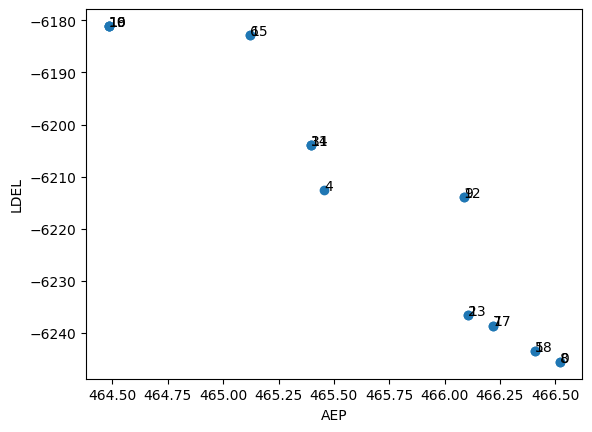

In [19]:
plt.scatter(optimizer.values1_P, optimizer.values2_P)
for i in range(optimizer.pop_size):
    plt.text(optimizer.values1_P[i], optimizer.values2_P[i], str(i))

plt.xlabel('AEP')
plt.ylabel('LDEL')

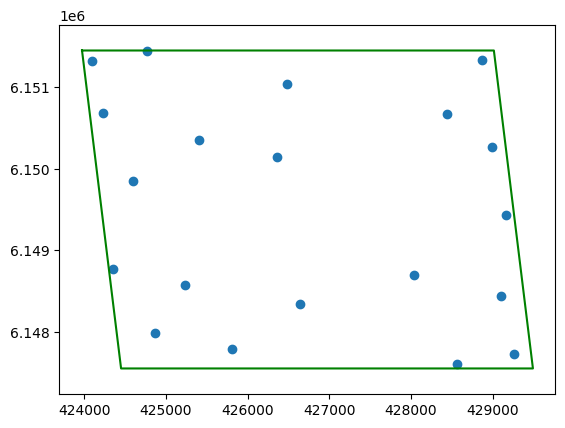

In [23]:
i = 0
plt.scatter(optimizer.P[i][:,0], optimizer.P[i][:,1])

# # 绘制多边形区域
for polygon in multi_polygon.geoms:
    plt.plot(*polygon.exterior.xy, color='g')
plt.axis('equal')
plt.show()

In [21]:
# import multiprocessing
# import numpy as np

# def evaluation_individual(individual):
#     # 将数据处理函数定义为工作者进程可被调用的静态函数
#     func1 = individual**2
#     func2 = individual**3
#     return func1, func2

# # population 数据也从主块中移出以便在 Jupyter 中运行
# population = np.random.rand(100, 1)

# # 使用 pool.map，适用于并行化的版本
# pool = multiprocessing.Pool()  # 不使用 with 方式

# try:
#     results = pool.map(evaluation_individual, population)

# finally:
#     # 确保在所有情况下池都能合理关闭
#     pool.close()
#     pool.join()

# # 处理返回结果
# func1_values, func2_values = zip(*results)
# func1_values = list(func1_values)
# func2_values = list(func2_values)

# print(func1_values)
# print(func2_values)

In [22]:
# from joblib import Parallel, delayed
# import numpy as np

# def evaluation_individual(individual):
#     return individual**2, individual**3

# population = np.random.rand(100, 1)
# parallel_obj = Parallel(n_jobs=4)
# results = parallel_obj(delayed(evaluation_individual)(ind) for ind in population)

# func1_values, func2_values = zip(*results)
# func1_values = list(func1_values)
# func2_values = list(func2_values)

# print(func1_values)
# print(func2_values)